# LinkedIn Network Analysis
Date: 28 November 2021

In [1]:
## Installing Libraries

import numpy as np
import pandas as pd
import networkx as nx
from pyvis import network as net
import janitor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML


/Users/a844133yara.com/.pyenv/versions/3.9.5/envs/python_playground/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
## Loading dataset
df = pd.read_csv('data/Connections.csv',skiprows=2)
df.info() # summary info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     397 non-null    object
 1   Last Name      397 non-null    object
 2   Email Address  7 non-null      object
 3   Company        390 non-null    object
 4   Position       390 non-null    object
 5   Connected On   400 non-null    object
dtypes: object(6)
memory usage: 18.9+ KB


At a quick glance, I have about 400 connections. 

## Data Cleaning

I will perform some cleaning, remove unnecessary attributes and remove null values from the data.

In [3]:
new_df = (
        df.clean_names() # remove spacing and capitalisation
        .drop(columns=['first_name','last_name','email_address']) # dropped first, last and email
        .dropna(subset=['company','position']) # remove null values in company and position
        .to_datetime('connected_on', format='%d %b %Y') # convert date column to datetime object
)
new_df.head()

,company,position,connected_on
0,InfoCepts,Talent Acquisition Lead,2021-11-28
1,Yara International,Associate data engineer,2021-11-27
2,Yara International,"Lead Recruiter, Digital Ag Solutions",2021-11-25
3,Yara International,Data Scientist,2021-11-25
4,Yara International,Associate Digital Information Specialist,2021-11-25


## Data Exploration

1. New connections over time
2. Top 15 companies my connections work at
3. Top 15 roles my connections work as

### New Connections over time

<AxesSubplot:>

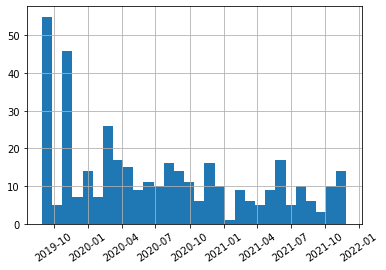

In [4]:
new_df.connected_on.hist(xrot=35,bins=30)

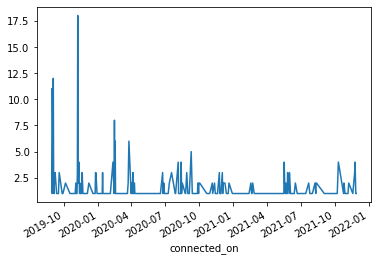

In [5]:
daily_connections = (new_df
                    .groupby(by=['connected_on']) # group by date
                    .size() # sum up new connections per day
                    .plot() # plot line chart
)

Looking at the number of new connections over time since i joined LinkedIn, bulk of my connections were created during the start - period between end 2019 and start of 2020).

### Top 15 companies my connections work at

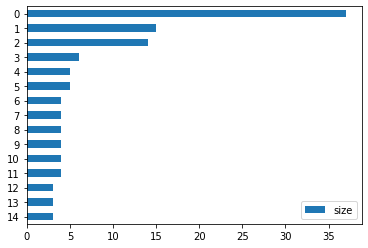

In [6]:
companies_count = (new_df
                    .groupby(by=['company']) # group by country
                    .size() # sum up count for each company
                    .to_frame('size') # convert to frame
                    .sort_values(by=['size'],ascending=False) # sort by descending order
                    .reset_index()
)
companies_count.head(15).plot(kind='barh').invert_yaxis() # convert to horizontal plot

### Top 15 roles my connections are working in

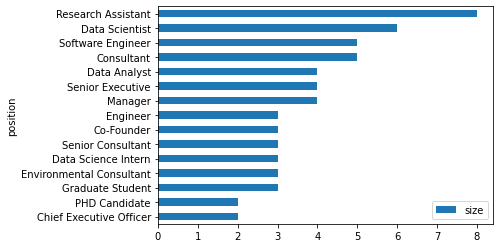

In [7]:
position_count = (new_df
                    .groupby(by=['position']) # group by country
                    .size() # sum up count for each company
                    .to_frame('size') # convert to frame
                    .sort_values(by=['size'],ascending=False) # sort by descending order
)
position_count.head(15).plot(kind='barh').invert_yaxis() # convert to horizontal plot

The top 3 companies my connections are working in are from Yara, Archisen and NTU, which is expected given that I did my undergraduate degree in NTU, worked at Archisen after graduation before joining Yara International.

Most of my connections are Research Assistants, Data Scientist and Software Engineers. 

## Network Analysis

In [8]:
companies_count.reset_index(inplace=True,drop=True)
companies_count_reduced = companies_count.loc[companies_count['size'] >=2]
print(companies_count_reduced.shape)

(42, 2)


In [9]:
position_count.reset_index(inplace=True)
position_count_reduced = position_count.loc[position_count['size'] >=2]
print(position_count_reduced.shape)

(35, 2)


In [20]:
# Initialise Graph
g1 = nx.Graph()
g1.add_node('root') # initialising myself as centrala node

# 
for id,row in companies_count_reduced.iterrows():

    # store company name and count
    company = row['company']
    count = row['size']
    
    title = f"<b>{company}</b> - {count}"
    # extract the positions my connections hold and store them in a set to prevent duplication
    positions = set([x for x in new_df[company == new_df['company']]['position']])
    positions = ''.join('<li>{}</li>'.format(x) for x in positions)

    position_list = f"<ul>{positions}</ul>"
    hover_info = title + position_list

    g1.add_node(company, size = count*2, title = hover_info, color='#3449eb')
    g1.add_edge('root',company,color='grey')

# Generate the graph
company_nt = net.Network(height='700px', width='700px', bgcolor="grey", font_color='white',notebook=True)
company_nt.from_nx(g1)
company_nt.hrepulsion()

company_nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [19]:
# initialize graph
g2 = nx.Graph()
g2.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for id, row in position_count_reduced.iterrows():

  count = f"{row['size']}"
  position= row['position']
  
  g2.add_node(position, size=count, color='#3449eb', title=count)
  g2.add_edge('root', position, color='grey')

# generate the graph
position_nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white', notebook = True)
position_nt.from_nx(g2)
position_nt.hrepulsion()

position_nt.show('position_graph.html')
display(HTML('position_graph.html'))